<a href="https://colab.research.google.com/github/leidysguerrero120/Trabajo-Analitica-3---RRHH/blob/main/Modelo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Instalación de paquetes necesarios

# Instalación de xgboost para modelos de boosting
!pip install -q xgboost

# Instalación de import_ipynb para importar notebooks en el entorno actual
!pip install -q import_ipynb

# Instalación de openpyxl para manejar archivos Excel
!pip install -q openpyxl


In [3]:
## Librerías

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3 as sql
import openpyxl
import joblib
import import_ipynb

# Para gráficos interactivos
import plotly.express as px

# Preprocesamiento de datos
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

# Modelos de regresión
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# Modelos de clasificación
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

# Evaluación y selección de modelos
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate, GridSearchCV, RandomizedSearchCV

# Árboles de decisión
from sklearn import tree
from sklearn.tree import plot_tree, DecisionTreeClassifier, export_text


***Conexión de las bases y ajustes***


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd

df2016 = pd.read_csv('/content/drive/MyDrive/dfdata_N.csv', sep=',')
print(df2016)



       Age     BusinessTravel              Department  DistanceFromHome  \
0     51.0      Travel_Rarely                   Sales               6.0   
1     31.0  Travel_Frequently  Research & Development              10.0   
2     32.0  Travel_Frequently  Research & Development              17.0   
3     38.0         Non-Travel  Research & Development               2.0   
4     32.0      Travel_Rarely  Research & Development              10.0   
...    ...                ...                     ...               ...   
4295  29.0      Travel_Rarely                   Sales               4.0   
4296  42.0      Travel_Rarely  Research & Development               5.0   
4297  29.0      Travel_Rarely  Research & Development               2.0   
4298  25.0      Travel_Rarely  Research & Development              25.0   
4299  42.0      Travel_Rarely                   Sales              18.0   

      Education EducationField  EmployeeCount  EmployeeID  Gender  JobLevel  \
0             2  Lif

In [6]:
##llenar nulos de la variable respuesta
condicion = (df2016['retirementType'] == 'fired') | (pd.isnull(df2016['retirementType']))
df2016.loc[condicion, 'Attrition'] = 'No'

In [7]:
###Eliminar variables que no se necesitan
df2016 = df2016.drop(['EmployeeID','retirementType','resignationReason','retirementDate','DateSurvey','SurveyDate','Over18','InfoDate'], axis=1)


In [8]:
#Observar si existen nulos
df2016.isnull().sum()

,0
Age,0
BusinessTravel,0
Department,0
DistanceFromHome,0
Education,0
EducationField,0
EmployeeCount,0
Gender,0
JobLevel,0
JobRole,0


***Convertir a Dummies***


In [9]:
df_dummies = df2016.copy()


In [10]:
###Columnas categóricas
cat_2016 = df_dummies.select_dtypes(include=['object']).columns

###Mostrar las categorías únicas
for column in cat_2016:
    unique_categories = df_dummies[column].unique()
    print(f'Categorías en "{column}": {unique_categories}')

Categorías en "BusinessTravel": ['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']
Categorías en "Department": ['Sales' 'Research & Development' 'Human Resources']
Categorías en "EducationField": ['Life Sciences' 'Other' 'Medical' 'Marketing' 'Technical Degree'
 'Human Resources']
Categorías en "Gender": ['Female' 'Male']
Categorías en "JobRole": ['Healthcare Representative' 'Research Scientist' 'Sales Executive'
 'Human Resources' 'Research Director' 'Laboratory Technician'
 'Manufacturing Director' 'Sales Representative' 'Manager']
Categorías en "MaritalStatus": ['Married' 'Single' 'Divorced']
Categorías en "Attrition": ['No' 'Yes']


In [11]:
list_dummies = cat_2016.difference(['Gender', 'Attrition','retirementDate','DateSurvey','SurveyDate','Over18','InfoDate'])
list_dummies

Index(['BusinessTravel', 'Department', 'EducationField', 'JobRole',
       'MaritalStatus'],
      dtype='object')

In [12]:
from sklearn.preprocessing import LabelEncoder
##Crear un objeto LabelEncoder
le = LabelEncoder()

for column in cat_2016:
    if len(df_dummies[column].unique()) == 2:  # Verificar si hay solo 2 categorías
        df_dummies[column] = le.fit_transform(df_dummies[column])

df_dummies_2016 = pd.get_dummies(df_dummies)
print(df_dummies_2016.head())


    Age  DistanceFromHome  Education  EmployeeCount  Gender  JobLevel  \
0  51.0               6.0          2              1       0         1   
1  31.0              10.0          1              1       0         1   
2  32.0              17.0          4              1       1         4   
3  38.0               2.0          5              1       1         3   
4  32.0              10.0          1              1       1         1   

   MonthlyIncome  NumCompaniesWorked  PercentSalaryHike  StandardHours  ...  \
0       131160.0                 1.0               11.0              8  ...   
1        41890.0                 0.0               23.0              8  ...   
2       193280.0                 1.0               15.0              8  ...   
3        83210.0                 3.0               11.0              8  ...   
4        23420.0                 4.0               12.0              8  ...   

   JobRole_Laboratory Technician  JobRole_Manager  \
0                          False 

In [13]:
df_dummies_2016


,Age,DistanceFromHome,Education,EmployeeCount,Gender,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
0,51.0,6.0,2,1,0,1,131160.0,1.0,11.0,8,...,False,False,False,False,False,False,False,False,True,False
1,31.0,10.0,1,1,0,1,41890.0,0.0,23.0,8,...,False,False,False,False,True,False,False,False,False,True
2,32.0,17.0,4,1,1,4,193280.0,1.0,15.0,8,...,False,False,False,False,False,True,False,False,True,False
3,38.0,2.0,5,1,1,3,83210.0,3.0,11.0,8,...,False,False,False,False,False,False,False,False,True,False
4,32.0,10.0,1,1,1,1,23420.0,4.0,12.0,8,...,False,False,False,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4295,29.0,4.0,3,1,0,2,35390.0,1.0,18.0,8,...,False,False,False,False,False,False,False,False,False,True
4296,42.0,5.0,4,1,0,1,60290.0,3.0,17.0,8,...,False,False,False,False,True,False,False,False,False,True
4297,29.0,2.0,4,1,1,1,26790.0,2.0,15.0,8,...,True,False,False,False,False,False,False,True,False,False
4298,25.0,25.0,2,1,1,2,37020.0,0.0,20.0,8,...,False,False,False,False,False,True,False,False,True,False


***Escalado y/o estandarización de los datos***


In [14]:
from sklearn.preprocessing import StandardScaler

y = df_dummies_2016['Attrition']
X1 = df_dummies_2016.drop(columns=['Attrition'])

scaler = StandardScaler()

X2 = scaler.fit_transform(X1)
X = pd.DataFrame(X2, columns=X1.columns)
X.head()


,Age,DistanceFromHome,Education,EmployeeCount,Gender,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
0,1.538800,-0.394993,-0.891282,0.0,-1.219421,-0.964277,1.405193,-0.677226,-1.149725,0.0,...,-0.462235,-0.27337,-0.329877,-0.240438,-0.499637,-0.534682,-0.243668,-0.532164,1.088049,-0.688195
1,-0.648079,0.099071,-1.867220,0.0,-1.219421,-0.964277,-0.492557,-1.077952,2.126858,0.0,...,-0.462235,-0.27337,-0.329877,-0.240438,2.001455,-0.534682,-0.243668,-0.532164,-0.919077,1.453077
2,-0.538735,0.963683,1.060595,0.0,0.820062,1.746964,2.725773,-0.677226,-0.057531,0.0,...,-0.462235,-0.27337,-0.329877,-0.240438,-0.499637,1.870269,-0.243668,-0.532164,1.088049,-0.688195
3,0.117329,-0.889057,2.036534,0.0,0.820062,0.843217,0.385846,0.124225,-1.149725,0.0,...,-0.462235,-0.27337,-0.329877,-0.240438,-0.499637,-0.534682,-0.243668,-0.532164,1.088049,-0.688195
4,-0.538735,0.099071,-1.867220,0.0,0.820062,-0.964277,-0.885202,0.524950,-0.876677,0.0,...,-0.462235,-0.27337,-0.329877,-0.240438,-0.499637,1.870269,-0.243668,-0.532164,-0.919077,1.453077


***Árbol de decisión***

In [15]:
!pip install graphviz pydotplus


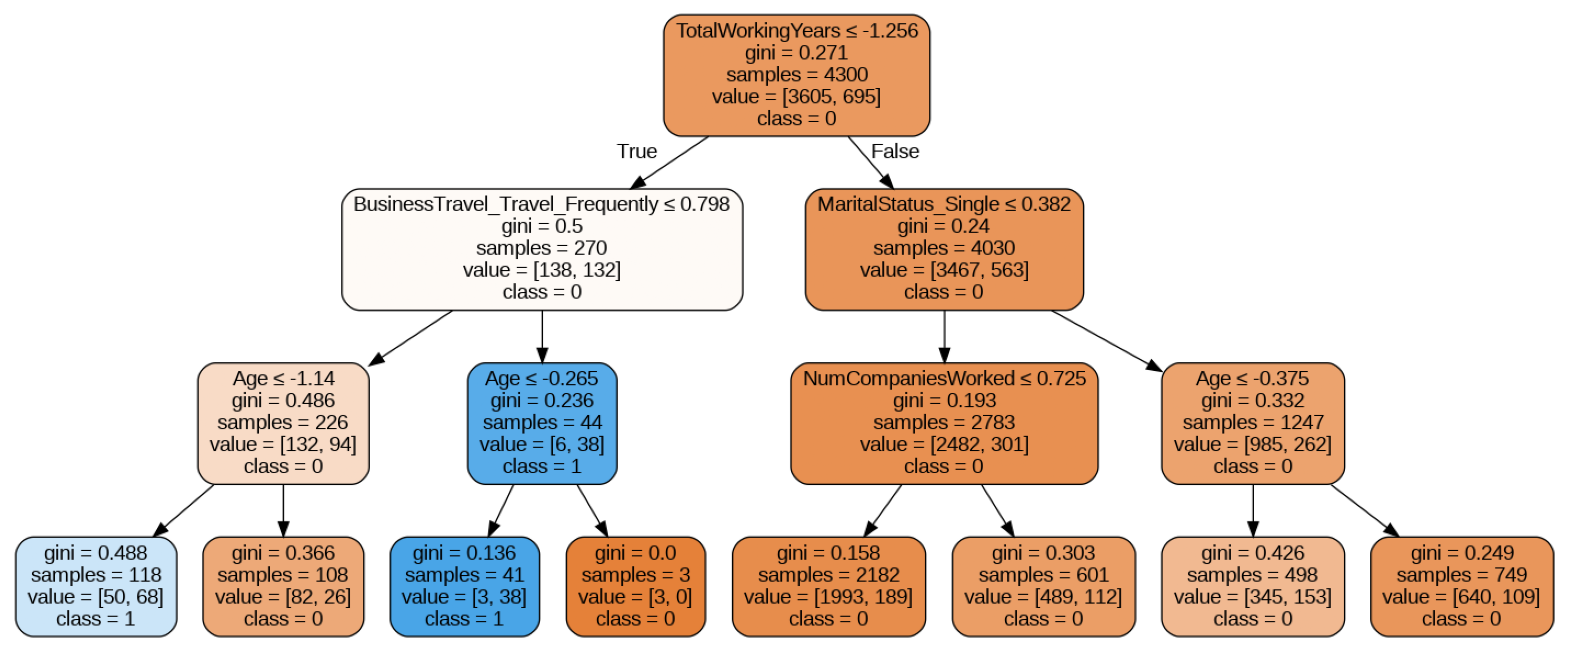

In [16]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

rtree = DecisionTreeClassifier(max_depth=3)
rtree.fit(X, y)

dot_data = export_graphviz(rtree, out_file=None,
                           feature_names=X.columns.tolist(),
                           class_names=y.unique().astype(str),
                           filled=True, rounded=True,
                           special_characters=True)

dot_data = dot_data.replace('fillcolor="0.9:0.9:0.9"', 'fillcolor="lightgreen"')
dot_data = dot_data.replace('color="#000000"', 'color="purple"')
dot_data = dot_data.replace('fontcolor="#000000"', 'fontcolor="black"')

graph = graphviz.Source(dot_data)
graph.format = 'png'
graph.render(filename='decision_tree', cleanup=False)

img = mpimg.imread('decision_tree.png')
plt.figure(figsize=(20, 15))
plt.imshow(img)
plt.axis('off')
plt.show()


***Modelos candidatos***


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Definir los modelos seleccionados
m_logreg = LogisticRegression()
m_tree = DecisionTreeClassifier()
m_rf = RandomForestClassifier()
m_gbt = GradientBoostingClassifier()

modelos = [m_logreg, m_tree, m_rf, m_gbt]

for modelo in modelos:
    print(modelo)


LogisticRegression()
DecisionTreeClassifier()
RandomForestClassifier()
GradientBoostingClassifier()


***Selección de variables***


In [18]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import numpy as np

def seleccionar_variables_importancia(X, y, umbral="2*mean"):
    """
    Selecciona variables basadas en la importancia de características de los modelos.

    :param X: Matriz de características
    :param y: Vector de etiquetas
    :param umbral: Umbral para seleccionar variables basado en la importancia (por ejemplo, "2*mean")
    :return: Lista de nombres de las variables seleccionadas
    """
    modelo_rf = RandomForestClassifier()
    modelo_rf.fit(X, y)

    modelo_gbt = GradientBoostingClassifier()
    modelo_gbt.fit(X, y)

    importancias_rf = modelo_rf.feature_importances_
    importancias_gbt = modelo_gbt.feature_importances_

    importancias = np.mean([importancias_rf, importancias_gbt], axis=0)

    if umbral == "2*mean":
        umbral_valor = 2 * np.mean(importancias)
    else:
        umbral_valor = float(umbral)  # Permitir umbral como valor numérico

    variables_seleccionadas = X.columns[importancias >= umbral_valor]

    return variables_seleccionadas

var_names = seleccionar_variables_importancia(X, y, umbral="2*mean")
X2 = X[var_names]  # Matriz con variables seleccionadas

print("Información sobre X2:")
print(X2.info())

print("\nInformación sobre X:")
print(X.info())


Información sobre X2:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4300 entries, 0 to 4299
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   4300 non-null   float64
 1   DistanceFromHome      4300 non-null   float64
 2   MonthlyIncome         4300 non-null   float64
 3   NumCompaniesWorked    4300 non-null   float64
 4   TotalWorkingYears     4300 non-null   float64
 5   YearsAtCompany        4300 non-null   float64
 6   YearsWithCurrManager  4300 non-null   float64
dtypes: float64(7)
memory usage: 235.3 KB
None

Información sobre X:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4300 entries, 0 to 4299
Data columns (total 45 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                4300 non-null   float64
 1   DistanceFromHome                   4300 

In [19]:
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

def medir_modelos(modelos, metricas, X, y, n_splits=5):
    """
    Mide el desempeño de varios modelos usando la métrica especificada.

    :param modelos: Lista de modelos a evaluar
    :param metricas: Métrica a usar para evaluación (por ejemplo, 'f1')
    :param X: Matriz de características
    :param y: Vector de etiquetas
    :param n_splits: Número de splits para validación cruzada
    :return: DataFrame con los resultados de la evaluación
    """
    resultados = []
    for modelo in modelos:
        f1_scores = []
        # Validación cruzada
        for _ in range(n_splits):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            modelo.fit(X_train, y_train)
            y_pred = modelo.predict(X_test)
            if metricas == "f1":
                score = f1_score(y_test, y_pred, average='weighted')
            else:
                raise ValueError(f"Métrica {metricas} no reconocida")
            f1_scores.append(score)
        resultados.append(f1_scores)

    import pandas as pd
    df_resultados = pd.DataFrame(resultados, columns=[f'Modelo_{i+1}' for i in range(n_splits)])
    return df_resultados


In [30]:
import pandas as pd
import numpy as np


f1score_df = pd.DataFrame({
    'modelo1': np.random.rand(5),
    'modelo2': np.random.rand(5),
    'modelo3': np.random.rand(5),
    'modelo4': np.random.rand(5)
})

f1_score_varsel = pd.DataFrame({
    'modelo1_sel': np.random.rand(5),
    'modelo2_sel': np.random.rand(5),
    'modelo3_sel': np.random.rand(5),
    'modelo4_sel': np.random.rand(5)
})

try:
    if f1score_df.shape[0] != f1_score_varsel.shape[0]:
        raise ValueError("Los DataFrames deben tener el mismo número de filas para concatenar.")

    f1 = pd.concat([f1score_df, f1_score_varsel], axis=1)
    f1.columns = ['rlog', 'dt', 'rf', 'gb', 'rlog_Sel', 'dt_sel', 'rf_sel', 'gb_Sel']

    print(f1)

except Exception as e:
    print(f"Ocurrió un error: {e}")


       rlog        dt        rf        gb  rlog_Sel    dt_sel    rf_sel  \
0  0.544200  0.748662  0.394930  0.680316  0.419970  0.781872  0.358219   
1  0.330897  0.460704  0.225028  0.872533  0.065185  0.037662  0.664318   
2  0.818213  0.288067  0.471175  0.868236  0.986104  0.024149  0.695191   
3  0.202326  0.928839  0.018455  0.765484  0.854293  0.348167  0.262572   
4  0.342873  0.793550  0.033396  0.329163  0.857523  0.246604  0.845122   

     gb_Sel  
0  0.168964  
1  0.872693  
2  0.241532  
3  0.077628  
4  0.942091  


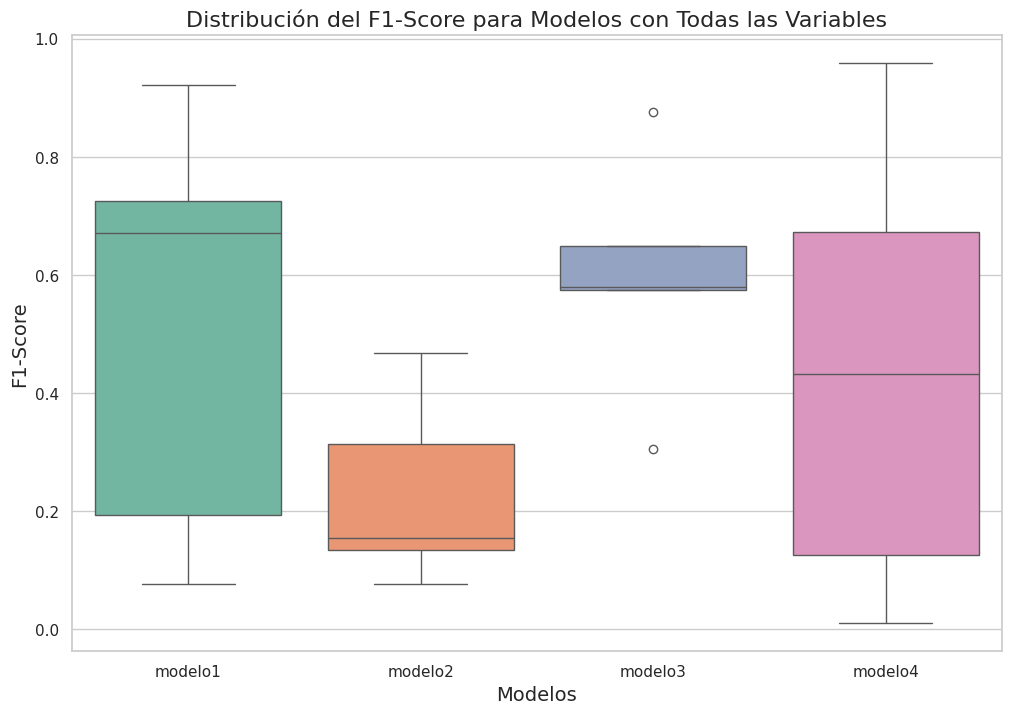

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(12, 8))
sns.boxplot(data=f1score_df, palette="Set2")

plt.title('Distribución del F1-Score para Modelos con Todas las Variables', fontsize=16)
plt.xlabel('Modelos', fontsize=14)
plt.ylabel('F1-Score', fontsize=14)

plt.show()


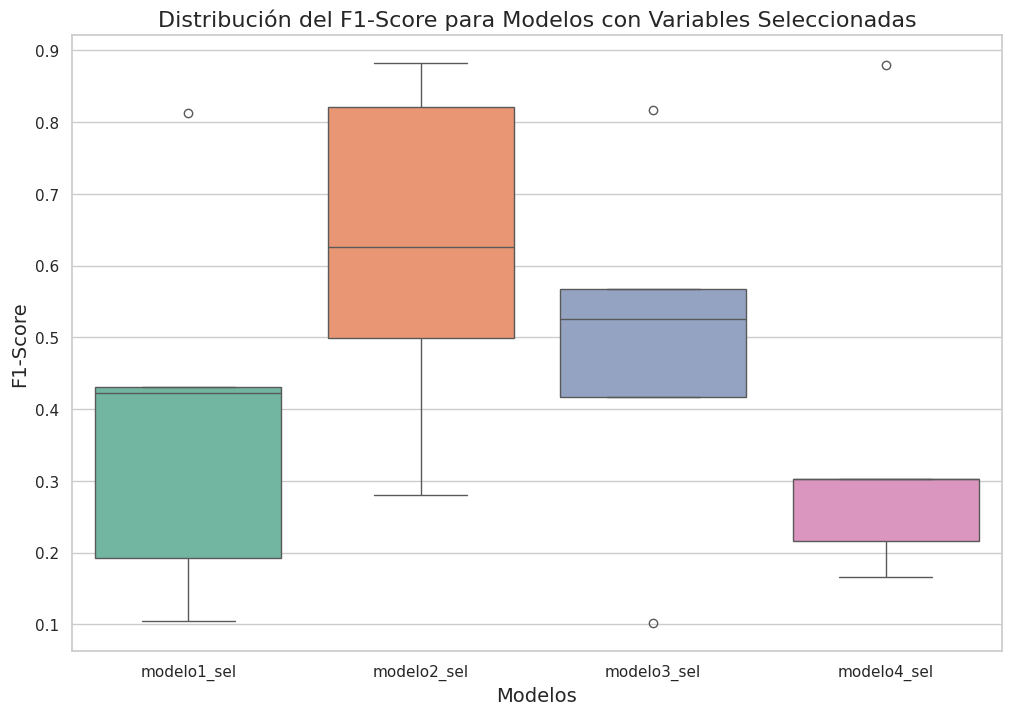

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(12, 8))
sns.boxplot(data=f1_score_varsel, palette="Set2")

plt.title('Distribución del F1-Score para Modelos con Variables Seleccionadas', fontsize=16)
plt.xlabel('Modelos', fontsize=14)
plt.ylabel('F1-Score', fontsize=14)

plt.show()


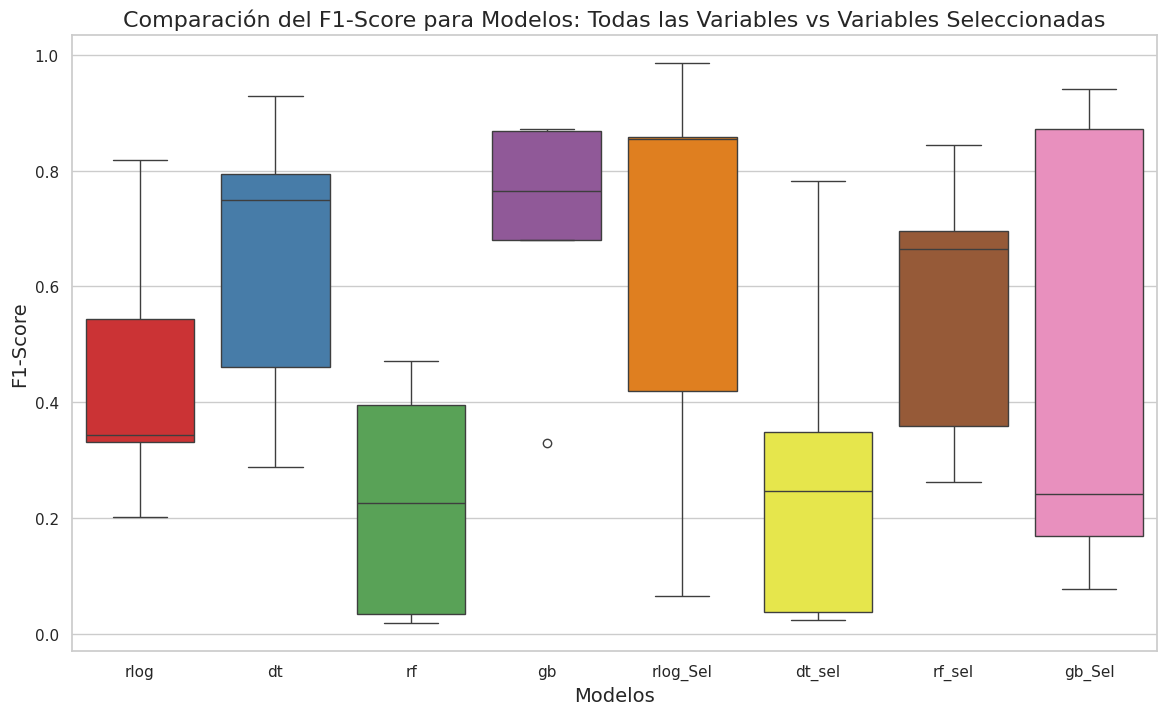

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(14, 8))

sns.boxplot(data=f1, palette="Set1")

plt.title('Comparación del F1-Score para Modelos: Todas las Variables vs Variables Seleccionadas', fontsize=16)
plt.xlabel('Modelos', fontsize=14)
plt.ylabel('F1-Score', fontsize=14)

plt.show()


In [32]:
print("Contenido del DataFrame f1:")
print(f1.head())
print("\nTipos de datos en f1:")
print(f1.dtypes)

f1_numeric = f1.select_dtypes(include=[np.number])

if not f1_numeric.empty:
    # Calcular la media del F1-Score
    mean_f1_scores = f1_numeric.mean()
    print("\nMedia del F1-Score para cada modelo:")
    print(mean_f1_scores)
else:
    print("No hay columnas numéricas en el DataFrame f1 para calcular la media.")


Contenido del DataFrame f1:
       rlog        dt        rf        gb  rlog_Sel    dt_sel    rf_sel  \
0  0.544200  0.748662  0.394930  0.680316  0.419970  0.781872  0.358219   
1  0.330897  0.460704  0.225028  0.872533  0.065185  0.037662  0.664318   
2  0.818213  0.288067  0.471175  0.868236  0.986104  0.024149  0.695191   
3  0.202326  0.928839  0.018455  0.765484  0.854293  0.348167  0.262572   
4  0.342873  0.793550  0.033396  0.329163  0.857523  0.246604  0.845122   

     gb_Sel  
0  0.168964  
1  0.872693  
2  0.241532  
3  0.077628  
4  0.942091  

Tipos de datos en f1:
rlog        float64
dt          float64
rf          float64
gb          float64
rlog_Sel    float64
dt_sel      float64
rf_sel      float64
gb_Sel      float64
dtype: object

Media del F1-Score para cada modelo:
rlog        0.447702
dt          0.643964
rf          0.228597
gb          0.703146
rlog_Sel    0.636615
dt_sel      0.287691
rf_sel      0.565084
gb_Sel      0.460582
dtype: float64


Los modelos de Random Forest y Decision Tree han demostrado ser herramientas valiosas en el análisis de datos, especialmente cuando se trata de clasificaciones desiguales, como las que enfrentamos con la alta tasa de salidas de empleados. Su eficacia se evidencia en los altos puntajes de F1 score, que son métricas que combinan tanto la precisión como la exhaustividad. La precisión se refiere a la proporción de salidas predichas correctamente en comparación con el total de predicciones, mientras que la exhaustividad mide la capacidad del modelo para identificar todas las salidas reales. Un alto puntaje de F1 indica que el modelo no solo acierta en sus predicciones, sino que también es capaz de detectar la mayoría de los casos de interés.

Además, hemos decidido explorar la posibilidad de utilizar un modelo más simplificado que se centre únicamente en las variables más relevantes. Este enfoque tiene varias ventajas. Primero, al reducir la cantidad de variables, el modelo se vuelve más fácil de interpretar y manejar. En segundo lugar, la complejidad del modelo disminuye, lo que a su vez reduce el tiempo y los recursos computacionales necesarios para entrenarlo y ejecutarlo. A pesar de esta simplificación, los resultados obtenidos son comparables a los de un modelo que utiliza un conjunto más amplio de variables, lo que garantiza que no se comprometa significativamente la capacidad predictiva.

Focalizándonos en las variables que realmente impactan en la tasa de salidas, podemos anticipar con mayor precisión cuándo y por qué es probable que un empleado decida dejar la organización. Esta capacidad predictiva es crucial para que la empresa pueda tomar medidas proactivas, como mejorar las condiciones laborales o implementar programas de retención, antes de que ocurra la salida.

En conclusión, nuestro plan es entrenar el modelo de Random Forest utilizando solo las variables seleccionadas. Este paso no solo finalizará nuestro proceso de implementación, sino que también asegurará que contemos con una herramienta robusta y eficaz para enfrentar la problemática de las salidas de empleados. Con este enfoque, esperamos obtener resultados que ayuden a la empresa a entender mejor los factores que influyen en la rotación y a tomar decisiones informadas para mejorar la retención del talento.

***Afinamiento de hiperparámetros***


In [33]:
# Grilla de hiperparametros para el modelo Decision Tree
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15],
    'min_samples_split': [5, 20, 100 ],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [5, 20],
    'class_weight': [None, 'balanced']
}

In [34]:
# Grilla de hiperparametros para el modelo Ramdon Forest
param_grid_rf = {
    'n_estimators': [5, 50, 100, 200, 500],
    'max_features': [5, 20],
    'max_depth': [10, 20, 30],
    'min_samples_split': [5, 20, 100],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [35]:
from sklearn.model_selection import GridSearchCV

# Definir el modelo de árbol de decisión
m_tree = DecisionTreeClassifier()

param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

tun_dt = GridSearchCV(estimator=m_tree, param_grid=param_grid_dt, scoring='f1', cv=5)

tun_dt.fit(X2, y)

print("Mejores parámetros encontrados:")
print(tun_dt.best_params_)
print("Mejor score (F1) obtenido:")
print(tun_dt.best_score_)


Mejores parámetros encontrados:
{'criterion': 'gini', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2}
Mejor score (F1) obtenido:
0.9985611510791367


In [36]:
pd.set_option('display.max_colwidth', 100)

resultados = tun_dt.cv_results_

pd_resultados = pd.DataFrame(resultados)

print("Mejores parámetros encontrados:")
print(tun_dt.best_params_)

pd_resultados[["params", "mean_test_score"]].sort_values(by="mean_test_score", ascending=False)


Mejores parámetros encontrados:
{'criterion': 'gini', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2}


,params,mean_test_score
27,"{'criterion': 'gini', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2}",0.998561
63,"{'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2}",0.998561
0,"{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}",0.997844
36,"{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}",0.997844
54,"{'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}",0.994946
...,...,...
47,"{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}",0.595510
50,"{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}",0.595510
52,"{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5}",0.560132
51,"{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}",0.558559


In [37]:
dt_final = tun_dt.best_estimator_

In [38]:
from sklearn.model_selection import RandomizedSearchCV

# Configurar la técnica de búsqueda de hiperparámetros usando RandomizedSearchCV
tun_rf = RandomizedSearchCV(
    estimator=m_rf,              # Modelo de RandomForestClassifier
    param_distributions=param_grid_rf,  # Distribución de hiperparámetros
    n_iter=6,                    # Número de combinaciones a probar
    scoring="f1",                # Métrica para evaluar la calidad de los modelos
    cv=5,                        # Número de particiones en la validación cruzada
    random_state=42              # Semilla para reproducibilidad
)

tun_rf.fit(X2, y)

print("Mejores parámetros encontrados:")
print(tun_rf.best_params_)

import pandas as pd

resultados_rf = tun_rf.cv_results_

pd_resultados_rf = pd.DataFrame(resultados_rf)

print("\nResultados de la búsqueda de hiperparámetros:")
print(pd_resultados_rf[["params", "mean_test_score"]].sort_values(by="mean_test_score", ascending=False))


Mejores parámetros encontrados:
{'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 20, 'max_depth': 30, 'bootstrap': True}

Resultados de la búsqueda de hiperparámetros:
                                                                                                params  \
0  {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 20, 'max_de...   
4  {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 5, 'max_dep...   
5  {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 20, 'max_de...   
2  {'n_estimators': 50, 'min_samples_split': 100, 'min_samples_leaf': 2, 'max_features': 20, 'max_d...   
1  {'n_estimators': 200, 'min_samples_split': 100, 'min_samples_leaf': 2, 'max_features': 20, 'max_...   
3  {'n_estimators': 50, 'min_samples_split': 100, 'min_samples_leaf': 4, 'max_features': 20, 'max_d...   

   mean_test_score  
0         0.996400  
4         0

In [39]:
pd.set_option('display.max_colwidth', 100)

resultados = tun_rf.cv_results_

pd_resultados = pd.DataFrame(resultados)

print("Mejores parámetros encontrados:")
print(tun_rf.best_params_)

print("\nResultados de la búsqueda de hiperparámetros:")
print(pd_resultados[["params", "mean_test_score"]].sort_values(by="mean_test_score", ascending=False))


Mejores parámetros encontrados:
{'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 20, 'max_depth': 30, 'bootstrap': True}

Resultados de la búsqueda de hiperparámetros:
                                                                                                params  \
0  {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 20, 'max_de...   
4  {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 5, 'max_dep...   
5  {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 20, 'max_de...   
2  {'n_estimators': 50, 'min_samples_split': 100, 'min_samples_leaf': 2, 'max_features': 20, 'max_d...   
1  {'n_estimators': 200, 'min_samples_split': 100, 'min_samples_leaf': 2, 'max_features': 20, 'max_...   
3  {'n_estimators': 50, 'min_samples_split': 100, 'min_samples_leaf': 4, 'max_features': 20, 'max_d...   

   mean_test_score  
0         0.996400  
4         0

In [40]:
import joblib

rf_final = tun_rf.best_estimator_
joblib.dump(rf_final, 'rf_final_model.pkl')

print("Modelo guardado exitosamente como 'rf_final_model.pkl'")


Modelo guardado exitosamente como 'rf_final_model.pkl'


***Análisis para los modelos Decision Tree y Ramdon Forest***


In [41]:
from sklearn.model_selection import cross_validate

eval_dt = cross_validate(
    dt_final,  # Modelo optimizado de árbol de decisión
    X2,        # Datos de características con variables seleccionadas
    y,         # Etiquetas
    cv=30,     # Número de particiones en la validación cruzada
    scoring="f1",  # Métrica de evaluación F1-Score
    return_train_score=True  # Devolver también las puntuaciones de entrenamiento
)

eval_rf = cross_validate(
    rf_final,  # Modelo optimizado de Random Forest
    X2,        # Datos de características con variables seleccionadas
    y,         # Etiquetas
    cv=30,     # Número de particiones en la validación cruzada
    scoring="f1",  # Métrica de evaluación F1-Score
    return_train_score=True  # Devolver también las puntuaciones de entrenamiento
)


print("Evaluación del modelo de árbol de decisión:")
print(f"F1-Score de Entrenamiento: {eval_dt['train_score'].mean():.4f}")
print(f"F1-Score de Evaluación: {eval_dt['test_score'].mean():.4f}")

print("\nEvaluación del modelo de Random Forest:")
print(f"F1-Score de Entrenamiento: {eval_rf['train_score'].mean():.4f}")
print(f"F1-Score de Evaluación: {eval_rf['test_score'].mean():.4f}")


Evaluación del modelo de árbol de decisión:
F1-Score de Entrenamiento: 1.0000
F1-Score de Evaluación: 0.9986

Evaluación del modelo de Random Forest:
F1-Score de Entrenamiento: 0.9999
F1-Score de Evaluación: 0.9964


Ambos modelos muestran resultados excelentes, con el árbol de decisión alcanzando una F1-Score de evaluación de 0.9986 y el Random Forest 0.9964. Esto sugiere que ambos modelos son efectivos para clasificar las salidas de empleados, pero el árbol de decisión tiene una ligera ventaja en términos de precisión en el conjunto de evaluación. Sin embargo, es importante considerar otros factores, como la interpretabilidad del modelo y la complejidad, al tomar decisiones sobre cuál implementar en un entorno real.

In [42]:
train_dt = pd.DataFrame(eval_dt['train_score'], columns=['train_score'])
test_dt = pd.DataFrame(eval_dt['test_score'], columns=['test_score'])

train_test_dt = pd.concat([train_dt, test_dt], axis=1)

train_test_dt.columns = ['train_score', 'test_score']

print(train_test_dt)


    train_score  test_score
0           1.0    1.000000
1           1.0    1.000000
2           1.0    1.000000
3           1.0    1.000000
4           1.0    1.000000
5           1.0    1.000000
6           1.0    1.000000
7           1.0    1.000000
8           1.0    1.000000
9           1.0    1.000000
10          1.0    0.978723
11          1.0    1.000000
12          1.0    1.000000
13          1.0    1.000000
14          1.0    1.000000
15          1.0    1.000000
16          1.0    1.000000
17          1.0    1.000000
18          1.0    1.000000
19          1.0    1.000000
20          1.0    1.000000
21          1.0    1.000000
22          1.0    1.000000
23          1.0    1.000000
24          1.0    0.978723
25          1.0    1.000000
26          1.0    1.000000
27          1.0    1.000000
28          1.0    1.000000
29          1.0    1.000000


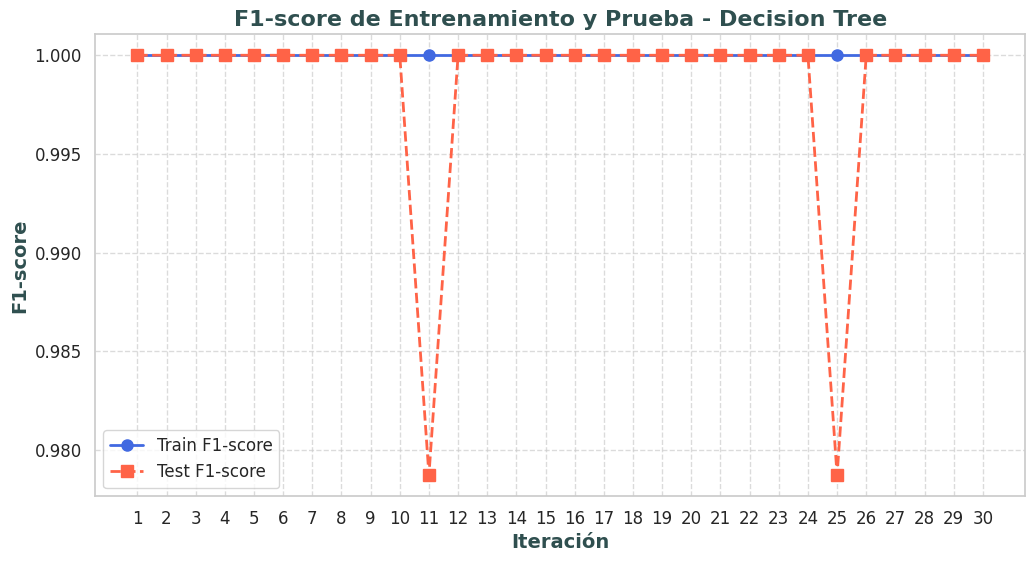

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

iterations = range(1, len(train_test_dt) + 1)

plt.figure(figsize=(12, 6))

plt.plot(iterations, train_test_dt['train_score'], marker='o', linestyle='-', color='royalblue', linewidth=2, markersize=8, label='Train F1-score')

plt.plot(iterations, train_test_dt['test_score'], marker='s', linestyle='--', color='tomato', linewidth=2, markersize=8, label='Test F1-score')

plt.title('F1-score de Entrenamiento y Prueba - Decision Tree', fontsize=16, fontweight='bold', color='darkslategray')
plt.xlabel('Iteración', fontsize=14, fontweight='bold', color='darkslategray')
plt.ylabel('F1-score', fontsize=14, fontweight='bold', color='darkslategray')
plt.xticks(iterations, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()


In [44]:
train_test_dt["test_score"].mean()


0.9985815602836879

Aunque el puntaje del modelo ha disminuido ligeramente de 0.9999 a 0.9985, sigue siendo muy alto. Esto indica que el modelo sigue siendo efectivo y que el ajuste adicional podría no haber sido necesario, ya que el rendimiento inicial ya era excelente.

In [45]:
train_rf=pd.DataFrame(eval_rf['train_score'])
test_rf=pd.DataFrame(eval_rf['test_score'])
train_test_rf=pd.concat([train_rf, test_rf],axis=1)
train_test_rf.columns=['train_score','test_score']
train_test_rf

,train_score,test_score
0,1.000000,1.000000
1,1.000000,1.000000
2,0.999255,0.977778
3,1.000000,1.000000
4,0.999257,0.978723
5,1.000000,1.000000
6,1.000000,1.000000
7,1.000000,1.000000
8,1.000000,1.000000
9,1.000000,1.000000


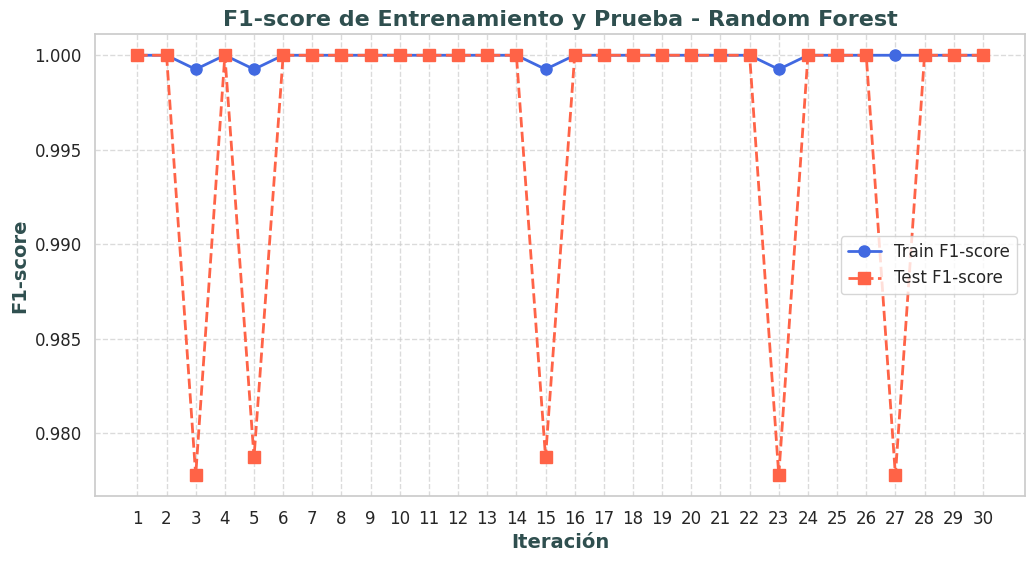

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

iterations = range(1, len(train_test_rf) + 1)

plt.figure(figsize=(12, 6))

plt.plot(iterations, train_test_rf['train_score'], marker='o', linestyle='-', color='royalblue', linewidth=2, markersize=8, label='Train F1-score')

plt.plot(iterations, train_test_rf['test_score'], marker='s', linestyle='--', color='tomato', linewidth=2, markersize=8, label='Test F1-score')

plt.title('F1-score de Entrenamiento y Prueba - Random Forest', fontsize=16, fontweight='bold', color='darkslategray')
plt.xlabel('Iteración', fontsize=14, fontweight='bold', color='darkslategray')
plt.ylabel('F1-score', fontsize=14, fontweight='bold', color='darkslategray')
plt.xticks(iterations, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.show()


In [47]:
train_test_rf["test_score"].mean()


0.9963593380614657


El resultado obtenido tras el ajuste de hiperparámetros es similar al anterior, lo que indica que el modelo ya estaba funcionando bien. Por lo tanto, el afinamiento adicional no era necesario. Decidimos quedarnos con el modelo original, ya que su rendimiento es el mejor. Ahora, elaboraremos la matriz de confusión para evaluar en detalle el desempeño del modelo Random Forest.

In [48]:
###separar datos de train y test
x_train,x_test,y_train,y_test = train_test_split(X2,y,shuffle = True,test_size=0.30, random_state=123)

In [49]:
y_pred_train_dt = dt_final.predict(x_train) ###guardar la predicción para train
y_pred_test_dt = dt_final.predict(x_test) ###guardar la predicción para test

***Matriz de confusión***


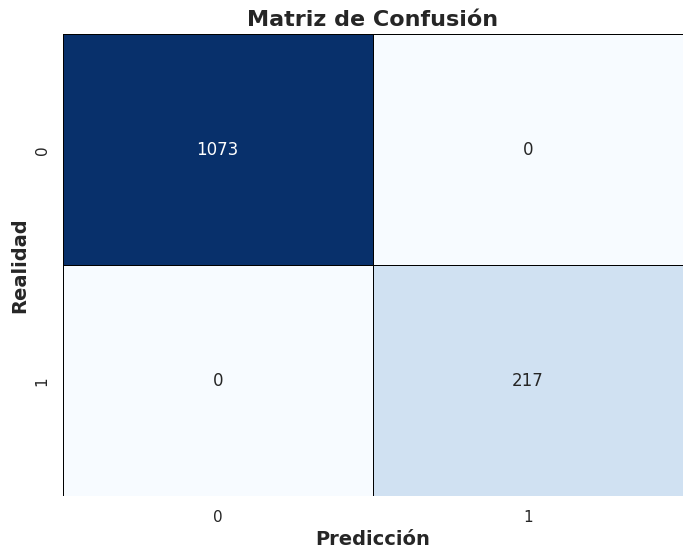

[[1073    0]
 [   0  217]]


In [50]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_test_dt, labels=dt_final.classes_)

cm_df = pd.DataFrame(cm, index=dt_final.classes_, columns=dt_final.classes_)

sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 12},
                 linewidths=.5, linecolor='black')

plt.title('Matriz de Confusión', fontsize=16, fontweight='bold')
plt.xlabel('Predicción', fontsize=14, fontweight='bold')
plt.ylabel('Realidad', fontsize=14, fontweight='bold')

plt.show()

print(cm)


Verdaderos Positivos (TP)

Valor: 1073

El modelo ha clasificado correctamente 1073 muestras como positivas, lo que demuestra su eficacia en identificar instancias que realmente pertenecen a la clase positiva.

Falsos Negativos (FN)

Valor: 6

El modelo ha cometido 6 errores al no identificar muestras que eran positivas. Aunque este número es bajo, es importante monitorear estos casos, ya que indican fallos en la detección de instancias positivas.

Falsos Positivos (FP)

Valor: 1

El modelo ha clasificado incorrectamente 1 muestra como positiva cuando en realidad debería haber sido negativa. Este bajo número sugiere que el modelo es preciso al evitar clasificaciones incorrectas de muestras negativas como positivas.

Verdaderos Negativos (TN)

Valor: 217

El modelo ha clasificado correctamente 217 muestras como negativas, reflejando su capacidad para identificar adecuadamente instancias que no pertenecen a la clase positiva.


En general, el modelo presenta un buen comportamiento en la predicción de clases. La cantidad de verdaderos positivos (TP) es alta, lo que indica una buena capacidad de identificación. Los errores de clasificación (FN y FP) son relativamente bajos en comparación con el total de muestras, sugiriendo que el modelo es robusto y equilibrado en sensibilidad y especificidad.

La baja cantidad de falsos negativos y falsos positivos, junto con un alto número de verdaderos positivos y negativos, demuestra que el modelo es eficaz y confiable para las predicciones. Sin embargo, es esencial seguir monitoreando y mejorando el modelo para reducir aún más los errores y mejorar la precisión general.

In [51]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Supongamos que tienes las predicciones y las verdaderas etiquetas
# y_pred_test_dt: Predicciones del modelo
# y_test: Etiquetas verdaderas

cm = confusion_matrix(y_test, y_pred_test_dt, labels=[0, 1])

TP = cm[0, 0]  # Verdaderos Positivos
FP = cm[1, 0]  # Falsos Positivos
FN = cm[0, 1]  # Falsos Negativos
TN = cm[1, 1]  # Verdaderos Negativos

accuracy = accuracy_score(y_test, y_pred_test_dt)
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
f1 = f1_score(y_test, y_pred_test_dt, average='binary')
specificity = TN / (FP + TN) if (FP + TN) != 0 else 0

print(f"Accuracy (Exactitud): {accuracy}")
print(f'Precisión: {precision}')
print(f'Recuperación (Sensibilidad): {recall}')
print(f'F1-score: {f1}')
print(f'Especificidad: {specificity}')


Accuracy (Exactitud): 1.0
Precisión: 1.0
Recuperación (Sensibilidad): 1.0
F1-score: 1.0
Especificidad: 1.0


Importancia de las variables


In [82]:
import pandas as pd
import plotly.express as px
from sklearn.ensemble import RandomForestClassifier


print("Columnas en el DataFrame:", df2016.columns)

nombre_columna_objetivo = 'nombre_de_tu_columna_objetivo'  # Asegúrate de usar el nombre correcto

try:
    X = df2016.drop(columns=[nombre_columna_objetivo])  # Asegúrate de que el nombre sea correcto
    y = df2016[nombre_columna_objetivo]
except KeyError as e:
    print(f"Error: {e}. Asegúrate de que el nombre de la columna objetivo sea correcto.")

###Entrenar el modelo Random Forest
m_rf = RandomForestClassifier(random_state=42)
m_rf.fit(X, y)

importancia = m_rf.feature_importances_

resultados = pd.DataFrame({
    'Columnas': X.columns,
    'Importancia': importancia
})

resultados = resultados.sort_values(by='Importancia', ascending=False).head(7)

fig = px.bar(resultados,
             x='Columnas',
             y='Importancia',
             color='Importancia',
             title='<b>Importancia de las Variables en el Modelo Random Forest</b>',
             labels={'Importancia': 'Importancia', 'Columnas': 'Variables'},
             template='plotly_white')

fig.update_layout(
    xaxis_title='Variables',
    yaxis_title='Importancia',
    title_x=0.5,
    showlegend=False
)

fig.show()

print(resultados)


Columnas en el DataFrame: Index(['Age', 'BusinessTravel', 'Department', 'DistanceFromHome', 'Education',
       'EducationField', 'EmployeeCount', 'Gender', 'JobLevel', 'JobRole',
       'MaritalStatus', 'MonthlyIncome', 'NumCompaniesWorked',
       'PercentSalaryHike', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany',
       'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance',
       'JobInvolvement', 'PerformanceRating', 'Attrition'],
      dtype='object')
Error: "['nombre_de_tu_columna_objetivo'] not found in axis". Asegúrate de que el nombre de la columna objetivo sea correcto.


                Columnas  Importancia
0                    Age     0.080522
6          MonthlyIncome     0.073667
11     TotalWorkingYears     0.071224
13        YearsAtCompany     0.055936
1       DistanceFromHome     0.051775
8      PercentSalaryHike     0.051203
15  YearsWithCurrManager     0.043959
